This notebook shows a method to estimate the latent demand of an appliance using our survey data.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from drs_sentani import get_survey
survey = get_survey()
import pysentani as sti

For the calculation to capture only the households that do not have the item but wish to purchase it, we have the following truth table.  The new column, app will buy, should only be true for those 

| | | |
|-|-|-|
| app now | app buy | app will buy |
|0|0|0 |
|0|1|1 |
|1|x|0 |

So app will buy is not(app now) and (app buy)

We calculate the derived column from the logical expression above.

In [2]:
# this will need a way to make more compact
# WB will buy or want to buy

def calc_willingness(survey, appliance):
    willing_label = 'WB' + appliance
    app_now_appliance = 'app_now/' + appliance
    app_buy_appliance = 'app_buy/' + appliance
    #print(WBlabel, app_now_appliance, app_buy_appliance)
    survey[willing_label] = ~survey[app_now_appliance].astype(bool) & survey[app_buy_appliance].astype(bool)

appliance_list = ['fridge', 'rice_cooker', 'fan', 'radio', 'TV', 'lighting' ]

WBlist = []
for appliance in appliance_list:
    calc_willingness(survey, appliance)
    WBlist.append('WB' + appliance)
#survey['WBTV'] = ~survey['app_now/TV'].astype(bool) & survey['app_buy/TV'].astype(bool)
#survey['WBfan'] = ~survey['app_now/fan'].astype(bool) & survey['app_buy/fan'].astype(bool)



We create a subset of the data with the columns we are interested in.

In [3]:
survey['access_type'] = sti.access_type(survey)
subsurvey = survey[['access_type'] + WBlist]

We use a group by to get percentages for responding households.  Our final analysis should also include the number of households excluded for not reporting.

In [4]:
analyzed = subsurvey.groupby('access_type').mean()
# next line necessary because I can't get melted to use index
analyzed['access_type'] = analyzed.index 
analyzed

,WBfridge,WBrice_cooker,WBfan,WBradio,WBTV,WBlighting,access_type
access_type,,,,,,,
PLN_grid,0.489499,0.323102,0.295638,0.206785,0.132472,0.021002,PLN_grid
PLN_microgrid,0.364706,0.382353,0.300000,0.229412,0.129412,0.023529,PLN_microgrid
community_microgrid,0.462963,0.407407,0.407407,0.203704,0.074074,0.074074,community_microgrid
no_access,0.466276,0.351906,0.340176,0.214076,0.126100,0.043988,no_access


We melt the array into long or tidy format to facilitate plotting.

In [5]:
melted = pd.melt(analyzed, 
                 id_vars=['access_type'],
                 value_vars=WBlist,
                 value_name='Percent Ownership')
melted

,access_type,variable,Percent Ownership
0,PLN_grid,WBfridge,0.489499
1,PLN_microgrid,WBfridge,0.364706
2,community_microgrid,WBfridge,0.462963
3,no_access,WBfridge,0.466276
4,PLN_grid,WBrice_cooker,0.323102
5,PLN_microgrid,WBrice_cooker,0.382353
6,community_microgrid,WBrice_cooker,0.407407
7,no_access,WBrice_cooker,0.351906
8,PLN_grid,WBfan,0.295638
9,PLN_microgrid,WBfan,0.300000


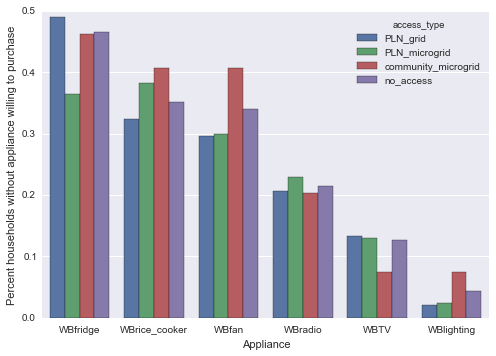

In [6]:
ax = sns.barplot(data=melted, x='variable', y='Percent Ownership', hue='access_type', order=WBlist)
ax.set_xlabel('Appliance')
ax.set_ylabel('Percent households without appliance willing to purchase')